# Graph Neural Network

In [ ]:
%pip install torch_geometric

引入必要的包


In [2]:
# type: ignore
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 定义GCN模型
定义两层GCN结构

In [ ]:
# 1. 定义GCN模型
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        # 第一层GCN：输入特征 -> 隐藏层
        self.conv1 = GCNConv(num_features, hidden_dim)
        # 第二层GCN：隐藏层 -> 输出类别
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x, edge_index):
        # x: 节点特征矩阵 [num_nodes, num_features]
        # edge_index: 边索引 [2, num_edges]
        
        # 第一层：图卷积 + ReLU激活 + Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第二层：图卷积
        x = self.conv2(x, edge_index)
        
        # 返回节点的类别预测（logits）
        return F.log_softmax(x, dim=1)

# 2. 加载Cora数据集（学术论文引用网络）
# 下载到 '../data/Cora' 目录
dataset = Planetoid(root='../data/Cora', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# 创建模型

In [6]:
# 3. 创建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(
    num_features=dataset.num_features,
    hidden_dim=16,
    num_classes=dataset.num_classes
).to(device)
data = data.to(device)

# 训练模型

In [7]:
# 4. 训练模型
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    # 前向传播
    out = model(data.x, data.edge_index)
    # 计算损失（只在训练集上）
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    # 反向传播
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        # 获取预测结果
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)
        
        # 计算各个数据集的准确率
        accs = []
        for mask_name in ['train_mask', 'val_mask', 'test_mask']:
            mask = data[mask_name]
            correct = pred[mask] == data.y[mask]
            acc = correct.float().mean().item()
            accs.append(acc)
        
        return accs

# 训练循环

In [ ]:
# 5. 训练循环
print("\n开始训练...")
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch {epoch:3d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.3f}, Val: {val_acc:.3f}, Test: {test_acc:.3f}')

# 最终评估

In [ ]:
# 6. 最终评估
train_acc, val_acc, test_acc = test()
print(f'\n最终结果:')
print(f'训练集准确率: {train_acc:.3f}')
print(f'验证集准确率: {val_acc:.3f}')
print(f'测试集准确率: {test_acc:.3f}')

# 可视化学习到的节点嵌入

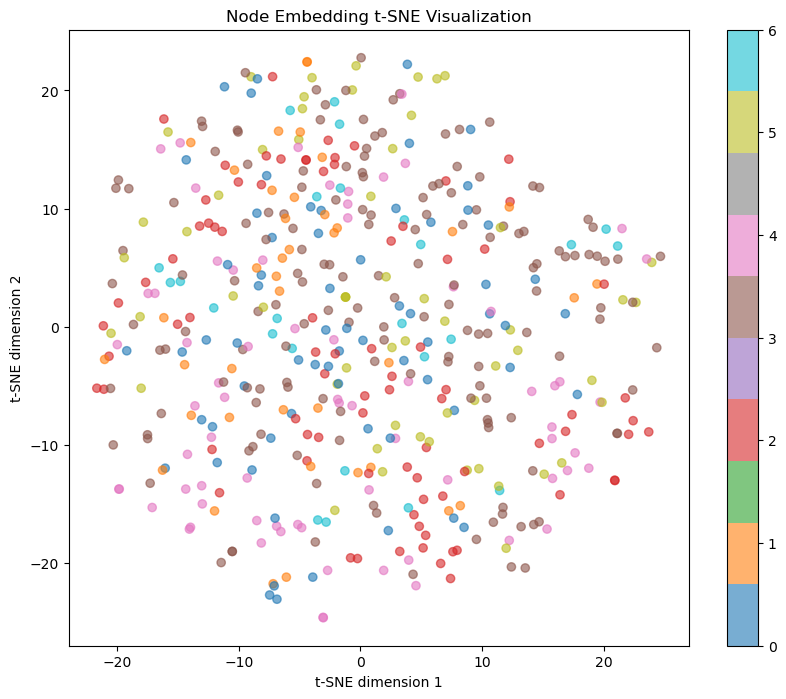

In [10]:
# 7. 可视化学习到的节点嵌入
model.eval()
with torch.no_grad():
    # 获取第一层的节点嵌入
    h = model.conv1(data.x, data.edge_index)
    h = F.relu(h)
    
    # 使用t-SNE降维到2D
    embeddings = h.cpu().numpy()
    labels = data.y.cpu().numpy()
    
    # 只可视化一部分节点以提高清晰度
    num_vis = 500
    indices = np.random.choice(len(embeddings), num_vis, replace=False)
    
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings[indices])
    
    # 绘制
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels[indices], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Node Embedding t-SNE Visualization')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

In [11]:
# 8. 理解GNN的消息传递机制
print("\n\nGNN消息传递机制解释:")
print("1. 每个节点初始有特征向量 x_i")
print("2. 在每一层，节点 i 聚合邻居节点的信息:")
print("   h_i = σ(W · mean({x_j : j ∈ N(i)} ∪ {x_i}))")
print("   其中 N(i) 是节点 i 的邻居集合")
print("3. 经过多层传播，每个节点能感知到多跳邻居的信息")
print("4. 最后一层输出用于预测任务")

# 简单示例：展示消息传递过程
print("\n消息传递示例（简化版）:")
# 创建一个小图
small_x = torch.tensor([[1.0], [2.0], [3.0], [4.0]])  # 4个节点
small_edges = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)  # 环形连接

print(f"初始节点特征: {small_x.squeeze().tolist()}")
print(f"边连接: 0->1, 1->2, 2->3, 3->0")



GNN消息传递机制解释:
1. 每个节点初始有特征向量 x_i
2. 在每一层，节点 i 聚合邻居节点的信息:
   h_i = σ(W · mean({x_j : j ∈ N(i)} ∪ {x_i}))
   其中 N(i) 是节点 i 的邻居集合
3. 经过多层传播，每个节点能感知到多跳邻居的信息
4. 最后一层输出用于预测任务

消息传递示例（简化版）:
初始节点特征: [1.0, 2.0, 3.0, 4.0]
边连接: 0->1, 1->2, 2->3, 3->0


In [12]:
# 简单的平均聚合
def simple_aggregate(x, edges):
    new_x = torch.zeros_like(x)
    for i in range(x.size(0)):
        # 找到节点i的所有邻居
        neighbors = edges[0][edges[1] == i]
        if len(neighbors) > 0:
            # 聚合邻居特征（这里用平均）
            new_x[i] = x[neighbors].mean()
        else:
            new_x[i] = x[i]
    return new_x

# 执行一步消息传递
new_features = simple_aggregate(small_x, small_edges)
print(f"一步传播后: {new_features.squeeze().tolist()}")
print("注意：每个节点现在包含了其邻居的信息！")

一步传播后: [4.0, 1.0, 2.0, 3.0]
注意：每个节点现在包含了其邻居的信息！
